# pyXpcm standard figures and diagnostic tools for a gridded timeseries product

In [1]:
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import intake
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))
import pyxpcm

from pyxpcm.models import pcm
from pyxpcm import datasets as pcmdata
from pyxpcm import plot as pcmplot
# from pyxpcm import stats as pcmstats

import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import matplotlib as mpl

# Load data

In [3]:
ds = pcmdata.load_isas15series()
print('This dataset holds: %.3f MB' % (ds.nbytes / 1e6))
print(ds)

This dataset holds: 141.684 MB
<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61, time: 12)
Coordinates:
  * time         (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2005-12-15
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    PSAL         (time, depth, latitude, longitude) float32 36.734 ... 34.917
    PSAL_ERR     (time, depth, latitude, longitude) float32 0.039 ... 0.006
    PSAL_PCTVAR  (time, depth, latitude, longitude) float32 19.0 22.0 ... 99.0
    TEMP         (time, depth, latitude, longitude) float32 21.234 ... 3.434
    TEMP_ERR     (time, depth, latitude, longitude) float32 0.25100002 ... 0.049000002
    TEMP_PCTVAR  (time, depth, latitude, longitude) float32 18.0 21.0 ... 99.0
    SST          (time, latitude, longitude) float32 21.234 21.246 ...

# Define/fit/predict a standard pyXpcm

In [3]:
# Define vertical axis and features to use:
z = ds['depth'].where(ds['depth']>=-500, drop=True)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

# features_pcm = {'temperature': z, 'sst': None}
# features_in_ds = {'temperature': 'TEMP', 'sst': 'SST'}

# Note that here we use the dataset vertical axis for performance reasons (no need for interpolation)
# We could use anything, eg: z = np.arange(0,-1000,-10)

In [4]:
# Instantiate a new pyXpcm:
m = pcm(K=3, features=features_pcm)

# Fit the model, directly onto the 3D data:
m.fit(ds, features=features_in_ds, dim='depth')
print(m,"\n")

# Hard/Fuzzy classify data:
m.predict(ds, features=features_in_ds, dim='depth', inplace=True)
m.predict_proba(ds, features=features_in_ds, dim='depth', inplace=True)

# Compute robustness of the classification:
ds.pyxpcm.robustness()
ds.pyxpcm.robustness_digit()

# Compute quantiles:
ds = ds.compute() # This is necessary if data are in dask arrays
for vname in ['TEMP', 'PSAL']:
    ds.pyxpcm.quantile([0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True)

print(ds)

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 6.344136 

<xarray.Dataset>
Dimensions:             (depth: 152, latitude: 53, longitude: 61, pcm_class: 3, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2
  * time                (time) datetime64[ns] 2005-01-15 ... 2005-12-15
  * latitude            (latitude) float64 30.02 30.46 30.89 ... 4

### Plot of the domain where data are available for this PCM

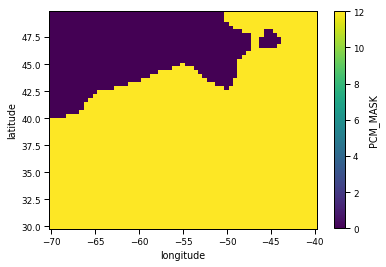

In [5]:
mask = ds.pyxpcm.mask(m, features=features_in_ds, dim='depth')
mask.sum(dim='time').plot()

In [6]:
# pyXpcm variables added to the dataset can be removed with:
# print('Before:', ds.data_vars)
# ds = ds.pyxpcm.drop_all()
# print('After cleaning:', ds.data_vars)

***

# Figure of results

## Maps

### Labels

/Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


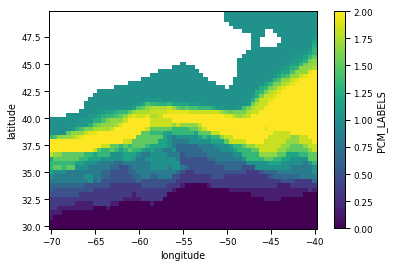

In [7]:
# Easiest way of ploting results:
ds['PCM_LABELS'].mean(dim='time').plot()

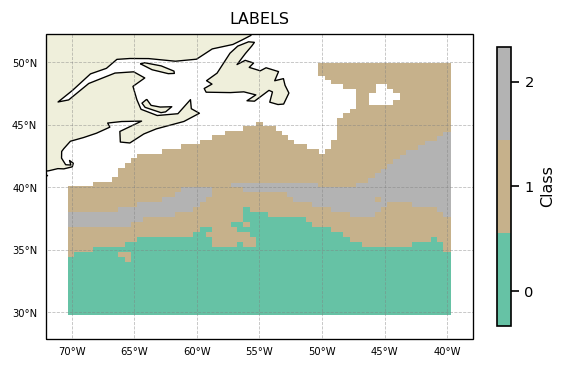

In [8]:
# Nicer map:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = m.plot.cmap()
ds['PCM_LABELS'].mean(dim='time').plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=m.K, add_colorbar=False)
cl = m.plot.colorbar(ax=ax)

gl = pcmplot.latlongrid(ax, fontsize=6, dx=5)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS')
plt.show()

### Probabilities of classes for each data point

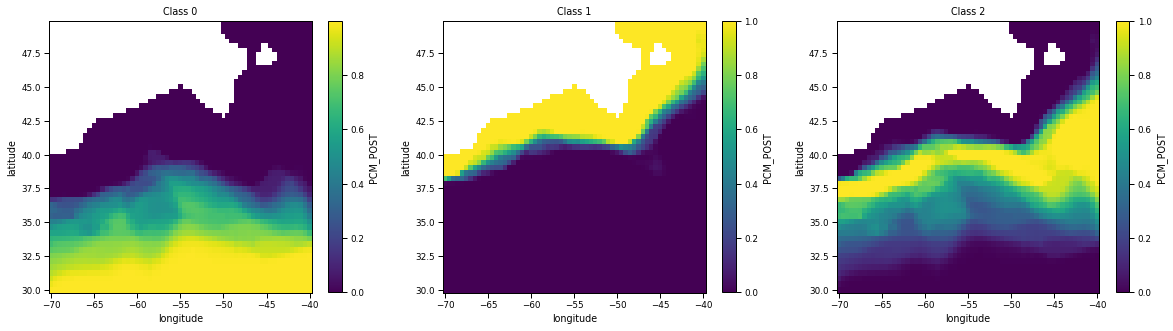

In [9]:
# Easiest way of ploting results:
fig, ax = m.plot.subplots(figsize=(20,5))
for k in m:
    ds['PCM_POST'].mean(dim='time').sel(pcm_class=k).plot(ax=ax[k])
    ax[k].set_title("Class %i" % k)

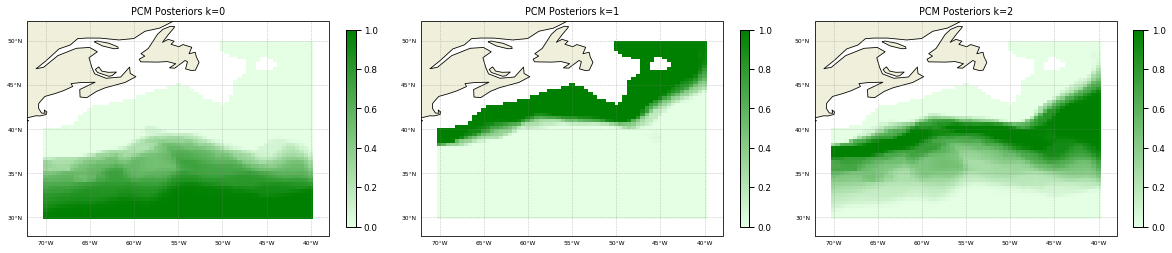

In [10]:
# Nicer maps:
cmap = sns.light_palette("green", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(20,5),subplot_kw=subplot_kw)
for k in m:
    sc = ds['PCM_POST'].mean(dim='time').sel(pcm_class=k).plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax[k])
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = pcmplot.latlongrid(ax[k], dx=5, dy=5)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)

### Robustness

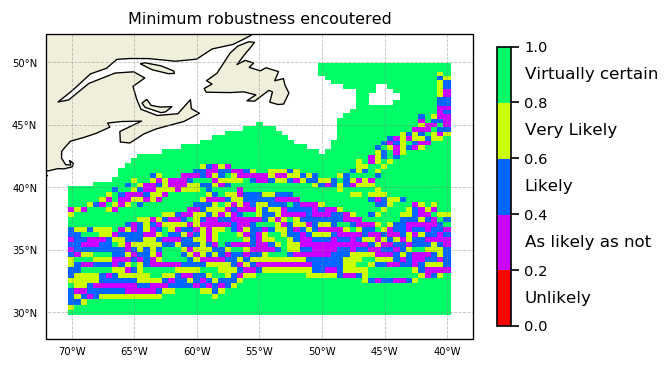

In [11]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-72,-38,28,51]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

cmap = pcmplot.cmap_robustess()
boundaries = ds['PCM_ROBUSTNESS_CAT'].attrs['bins']
rowl0 = ds['PCM_ROBUSTNESS_CAT'].attrs['legend']
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ds['PCM_ROBUSTNESS'].min(dim='time').plot.pcolormesh(cmap=cmap, transform=proj, vmin=0, vmax=1, add_colorbar=False, ax=ax)
cl = plt.colorbar(sc, ax=ax, fraction=0.03)
for (i,j) in zip(np.arange(0.1,1,1/5), rowl0):
    cl.ax.text(2, i, j, ha='left', va='center')

gl = pcmplot.latlongrid(ax)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Minimum robustness encoutered')
plt.show()

## Profiles

### Quantiles

Used to plot the typical class profiles

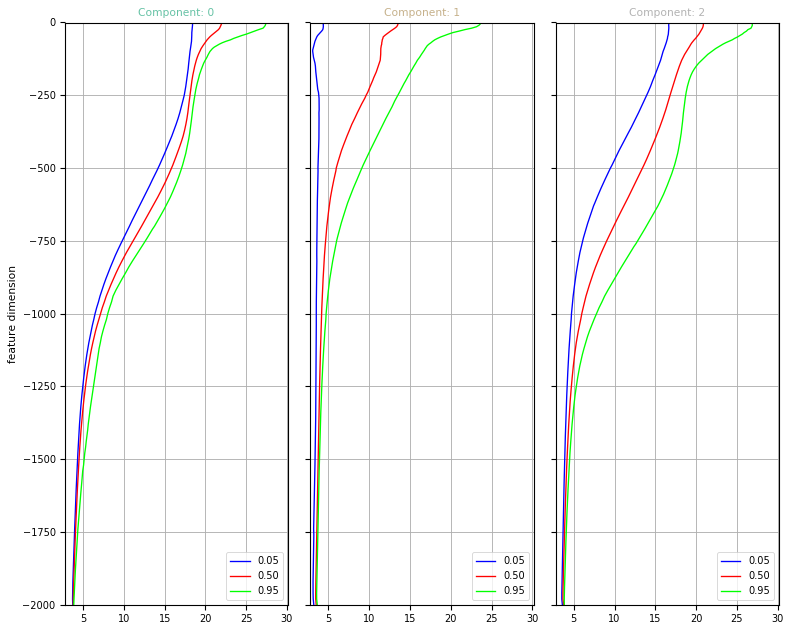

In [12]:
fig, ax = pcmplot.quant(m, ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)

# Figure of PCM properties

In [13]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Standard PCM:
m = pcm(K=3, features=features_pcm, maxvar=3) # We use a strong reduction (2-dim) to limit the dimensions and size of the plot
m.fit_predict(ds, features=features_in_ds, dim='depth');

## Scaler properties

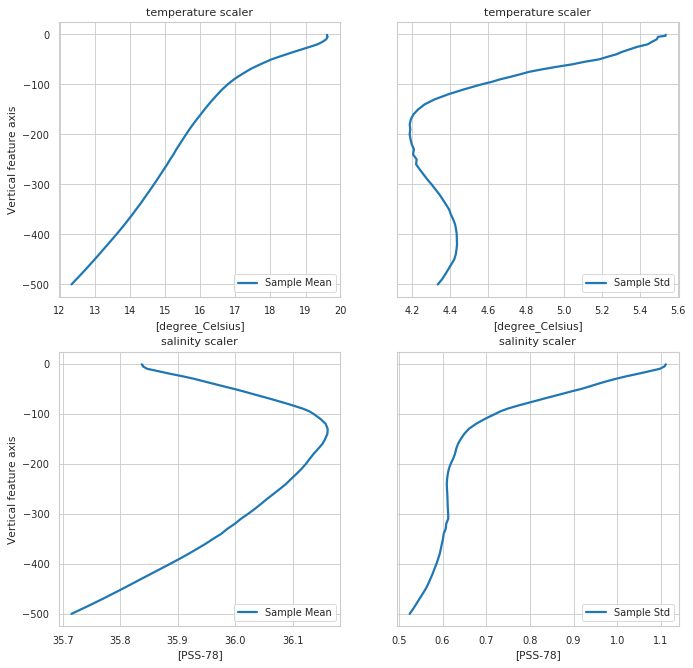

In [14]:
m.plot.scaler();
# Equivalent to:
# pcmplot.scaler(m)

# More options:
# m.plot.scaler(style='darkgrid')
# m.plot.scaler(style='darkgrid', subplot_kw={'ylim':[-1000,0]})

## Reducer properties

Plot eigen vectors for a PCA reducer or nothing if no reduced used

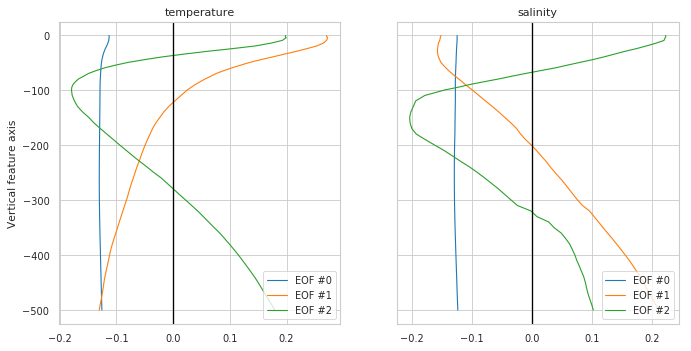

In [15]:
m.plot.reducer();
# Equivalent to:
# pcmplot.reducer(m)

# More options:
# m.plot.reducer(pcalist = range(0,4));
# m.plot.reducer(pcalist = range(0,4), style='darkgrid',  plot_kw={'linewidth':1.5}, subplot_kw={'ylim':[-1400,0]}, figsize=(12,10));

## Scatter plot of features, *as seen by the classifier*

In [16]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Standard PCM:
m = pcm(K=3, features=features_pcm, maxvar=2) # We use a strong reduction (2-dim) to limit the dimensions and size of the plot
m.fit_predict(ds, features=features_in_ds, dim='depth');

In [17]:
# To get access to pre-processed data for your own plot/analysis:
X, sampling_dims = m.preprocessing(ds, features=features_in_ds, dim='depth')
X

<xarray.DataArray (n_samples: 28056, n_features: 4)>
array([[-1.194323, -0.276805, -1.284964,  0.168858],
       [-1.189657, -0.272677, -1.287965,  0.161781],
       [-1.183537, -0.266829, -1.286424,  0.151505],
       ...,
       [ 1.481063, -0.071823,  1.517897, -0.268313],
       [ 1.407786, -0.109112,  1.442525, -0.28642 ],
       [ 1.489161, -0.123721,  1.495147, -0.290295]], dtype=float32)
Coordinates:
  * n_samples   (n_samples) int64 0 1 2 3 4 5 ... 28051 28052 28053 28054 28055
  * n_features  (n_features) <U13 'temperature_0' ... 'salinity_1'

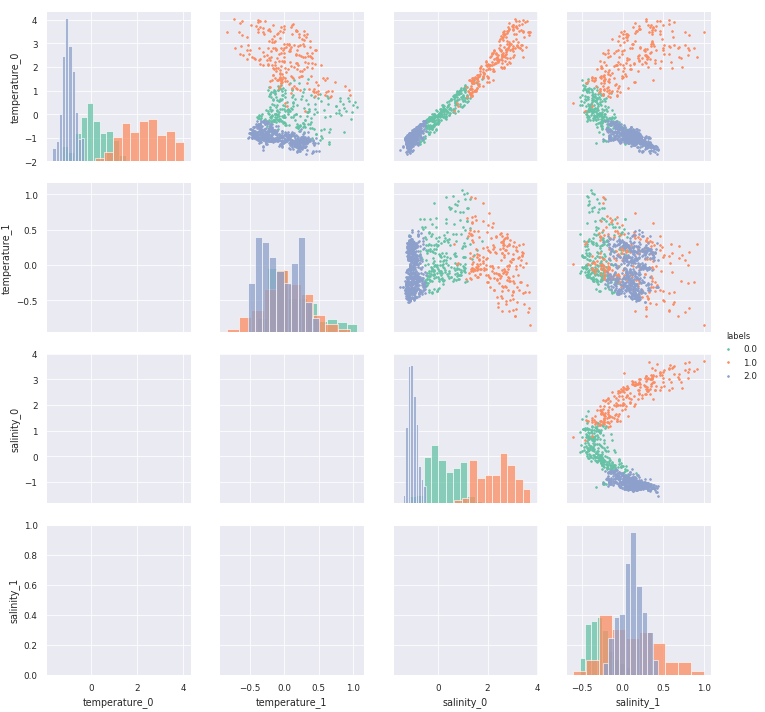

In [18]:
# Direct Figure:
g = m.plot.preprocessed(ds, features=features_in_ds, style='darkgrid', dim='depth')

# A posteriori adjustements:
# g.set(xlim=(-3,3),ylim=(-3,3))
# g.savefig('toto.png')

In [19]:
# Combine KDE with histrograms (very slow plot, so commented here):
# g = m.plot.preprocessed(ds, features=features_in_ds, kde=True)

# Diagnostics

## Debugging

Use option ``debug`` to print log messages 

In [20]:
# Clean up dataset of previous results:
ds = ds.pyxpcm.drop_all()

# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=1)

# Fit with log:
m.fit(ds, features=features_in_ds, dim='depth');

> Start preprocessing for fit
	> Preprocessing TEMP as temperature
	Input working arrays X and z with shapes: (28056, 152) (152,)
	Output axis is in the input axis, not need to interpolate, simple intersection
	Preprocessed arrays X with shapes: (28056, 5)
	Homogenisation for fit of temperature
	> Preprocessing PSAL as salinity
	Input working arrays X and z with shapes: (28056, 152) (152,)
	Output axis is in the input axis, not need to interpolate, simple intersection
	Preprocessed arrays X with shapes: (28056, 5)
	Homogenisation for fit of salinity
> Preprocessing finished, working with final X array of shape: (28056, 10)  and sampling dimensions: ['time', 'latitude', 'longitude']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings at execution time

In [21]:
# Create a PCM and use several methods to time:
m = pcm(K=3, features=features_pcm, timeit=True)
m.fit(ds, features=features_in_ds, dim='depth');
m.predict(ds, features=features_in_ds, dim='depth');
m.fit_predict(ds, features=features_in_ds, dim='depth');

  fit.1-preprocess.1-mask: 240 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 513 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 175 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 7 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 35 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 6 ms
  fit.1-preprocess.2-feature_temperature.total: 744 ms
  fit.1-preprocess: 745 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_salinity.1-ravel: 458 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 180 ms
  fit.1-preprocess.2-feature_salinity.3-scale_fit: 7 ms
  fit.1-preprocess.2-feature_salinity.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 41 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 10 ms
  fit.1-preprocess.2-feature_salinity.total: 706 ms
  fit.1-preprocess: 706 ms
  fit.1-preprocess.3-homogeniser: 6 ms
  fit.1-prep

In [22]:
# Timing are accessible through a dataframe in the timeit property:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                  240.154982
                           2-feature_temperature  1-ravel                513.476133
                                                  2-interp               175.829887
                                                  3-scale_fit              7.855177
                                                  4-scale_transform        5.270958
                                                  5-reduce_fit            35.250902
                                                  6-reduce_transform       6.504059
                                                  total                  744.992971
                           total                                        3157.878160
                           3-homogeniser          total                    7.471085
                           2-feature_salinity     1-ravel                458.665133
       

### Compare details of steps for each method

Sub-method,1-preprocess,2-fit,2-predict,3-score,3-xarray,4-predict,5-xarray,score
Method,,,,,,,,
fit,6309.942961,1633.674860,NaN,9.24015,NaN,NaN,NaN,NaN
fit_predict,5934.129715,1664.875746,NaN,19.71817,NaN,7.313967,1067.408323,9.823084
predict,6199.710846,NaN,28.02825,NaN,981.119871,NaN,NaN,25.650978


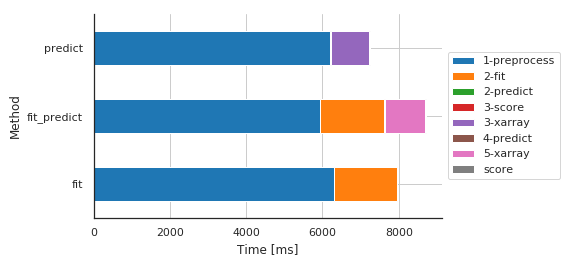

In [23]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method') # Default group/split
df

### Compare preprocessing steps for each method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,240.154982,1410.732746,1489.180088,7.471085,4.525900
fit_predict,267.481089,1376.594782,1303.085804,9.164333,6.605864
predict,163.559914,1287.853956,1633.599281,1.770020,9.397030


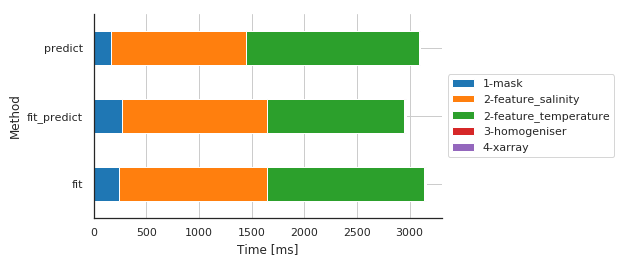

In [24]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Compare details of preprocessing steps for each method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,972.141266,356.163979,15.609264,10.725260,77.085972,16.980171
fit_predict,984.743118,310.460806,0.004768,16.226768,0.008106,27.527094
predict,967.938662,423.287153,0.005960,16.349316,0.015974,51.673174


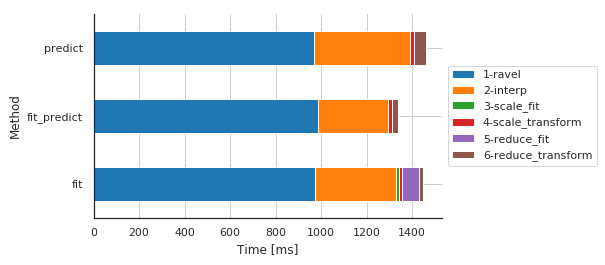

In [25]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Compare details of preprocessing steps for each feature

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,1444.566011,481.866121,7.757902,21.590233,41.842937,38.110495
2-feature_temperature,1480.257034,608.045816,7.862091,21.711111,35.267115,58.069944


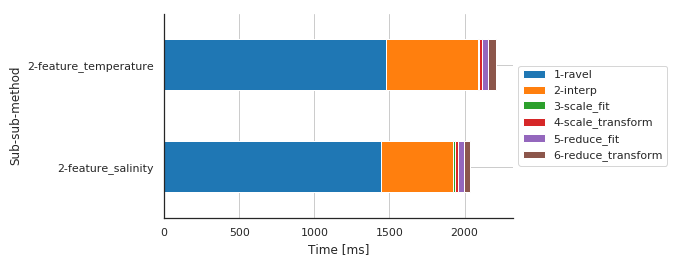

In [26]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method')
df

## Dask optimisation

To be done...

In [27]:
from distributed import Client, LocalCluster
cluster = LocalCluster(processes=True)
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:63003 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [28]:
from contextlib import contextmanager
import time
import dask_ml.preprocessing
from sklearn import preprocessing

@contextmanager
def timeit_context(out):
    startTime = time.time()
    yield
    elapsedTime = time.time() - startTime
    print('{} ms'.format(int(elapsedTime * 1000)))
    out.append(elapsedTime)
    return elapsedTime

In [29]:
# Compare scaler performances
m = pcm(K=3, features={'TEMP': ds['depth'].values}, 
        scaling=0, reduction=0, timeit=1, timeit_verb=0)
print(m)
ds = ds.chunk({'latitude':25, 'longitude':25, 'time':1})
print(ds)
with timeit_context():
    X, sampling_dims = m.preprocessing(ds, dim='depth')
    print(X)

<pcm 'gmm' (K: 3, F: 1)>
Number of class: 3
Number of feature: 1
Feature names: odict_keys(['TEMP'])
Fitted: False
Feature: 'TEMP'
	 Interpoler: <class 'pyxpcm.models.Vertical_Interpolator'>
	 Scaler: 'none', <class 'dask_ml.preprocessing.data.StandardScaler'>
	 Reducer: False, <class 'pyxpcm.models.NoTransform'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61, pcm_class: 3, quantile: 3, time: 12)
Coordinates:
  * pcm_class    (pcm_class) int64 0 1 2
  * time         (time) datetime64[ns] 2005-01-15 2005-02-15 ... 2005-12-15
  * latitude     (latitude) float64 30.02 30.46 30.89 ... 49.09 49.41 49.74
  * longitude    (longitude) float64 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
  * quantile     (quantile) float64 0.05 0.5 0.95
Data variables:
    PSAL         (time, depth, latitude, longitude) float32 dask.arra

TypeError: timeit_context() missing 1 required positional argument: 'out'

In [ ]:
scaler = dask_ml.preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
dt = dict()
with timeit_context(dt):
    scaler.fit(X.data)
    x = scaler.transform(X.data)
    print(x.shape, scaler.n_samples_seen_)
    plt.plot(scaler.mean_)
print(dt)

In [ ]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
with timeit_context():
    scaler.fit(X.values)
    x = scaler.transform(X.values)
#     print(x.shape, x[0,:])
    plt.plot(scaler.mean_)

In [ ]:
class xscaler():
    def __init__(self, with_mean=True, with_std=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.mean_ = None
        self.var_ = None
        self.fitted = False

    def fit(self, da):
        if self.with_mean:
            self.mean_ = da.data.mean(axis=0)
        if self.with_std:
            self.var_ = da.data.std(axis=0)
        self.fitted = True
        return self

    def transform(self, da):
        if not self.fitted:
            raise ValueError('Not fitted !')        
        if self.with_mean:
            da = da-self.mean_        
        if self.with_std:
            da = da/self.var_        
        return da

scaler = xscaler(with_mean=True, with_std=True)
X = xr.DataArray(np.empty())
chunk_list = [10, 100, 1000, 5000, 10000, 15000, 20000, None]
dt = list()
for chunk_size in chunk_list:
    x = X.chunk({'n_samples':chunk_size})
    with timeit_context(dt):
        scaler.fit(x)
        x = scaler.transform(x)
        plt.plot(scaler.mean_)
print(dt)

In [ ]:
chl = chunk_list
chl[-1] = X.shape[0]
plt.plot(chl, dt)